In [1]:
import numpy as np
import ssid
import quakeio
from ssid import modal, spec
from utilities import Config, extract_channels, list_files, print_modes, mode_statistics

### Data inputs

In [2]:
directory = "../CESMD/CE89324/"
pattern  = "????????*.[zZ][iI][pP]"

In [3]:
data_conf = Config()
data_conf.d = 8 # decimation factor

# PAINTER RIO DELL TRANSVERSE (CASE 1)
data_conf.inputs  = [17,3,20]
data_conf.outputs = [9,7,4]
# # PAINTER RIO DELL LONGITUDINAL (CASE 2)
# data_conf.inputs  = [15,1,18]
# data_conf.outputs = [11]

# # HWY8/MELOLAND TRANSVERSE (CASE 1)
# data_conf.inputs  = [2],
# data_conf.outputs = [5,7,9]
# # HWY8/MELOLAND TRANSVERSE (CASE 2)
# data_conf.inputs  = [11,2,26],
# data_conf.outputs = [5,7,9]
# # HWY8/MELOLAND LONGITUDINAL (CASE 3)
# data_conf.inputs  = [12,4,25],
# data_conf.outputs = [27,8]

# # CROWLEY TRANSVERSE (CASE 1)
# data_conf.inputs = [4]
# data_conf.outputs = [6,7,9]
# # CROWLEY TRANSVERSE (CASE 2)
# data_conf.inputs = [6,4,9]
# data_conf.outputs = [7]
# # CROWLEY TRANSVERSE (CASE 3)
# data_conf.inputs = [4]
# data_conf.outputs = [7]
# # CROWLEY LONGITUDINAL (CASE 4)
# data_conf.inputs = [5]
# data_conf.outputs = [8]

# # RIDGECREST TRANSVERSE (CASE 1)
# data_conf.inputs  = [4]
# data_conf.outputs = [6,7,9]

# # CAPISTRANO TRANSVERSE (CASE 1)
# data_conf.inputs  = [4]
# data_conf.outputs = [10,7]

# # HAYWARD TRANSVERSE (CASE 1)
# data_conf.inputs  = [2,7,25,18]
# data_conf.outputs = [13,15,23,20]
# # HAYWARD LONGITUDINAL
# data_conf.inputs  = [3,6,17],
# data_conf.outputs = [12,14,19]

# # BERNARDINO TRANSVERSE BENT 3 (CASE 1)
# data_conf.inputs  = [6]
# data_conf.outputs = [7,8]
# # BERNARDINO TRANSVERSE BENT 8 (CASE 2)
# data_conf.inputs  = [24]
# data_conf.outputs = [19,20]
# # BERNARDINO LONGITUDINAL BENT 3 (CASE 3)
# data_conf.inputs  = [4]
# data_conf.outputs = [10]
# # BERNARDINO LONGITUDINAL BENT 8 (CASE 4)
# data_conf.inputs  = [22]
# data_conf.outputs = [17,18]

# # VINCENT THOMAS (CE14406) TRANSVERSE (CASE 1)
# data_conf.inputs  = [1,9,24]
# data_conf.outputs = [2,5,7]
# # VINCENT THOMAS TRANSVERSE DENSE (CASE 2)
# data_conf.inputs  = [1,9,24]
# data_conf.outputs = [2,4,5,6,7]
# # VINCENT THOMAS VERTICAL SOUTH DECK EDGE (CASE 3)
# data_conf.inputs  = [14,19,26]
# data_conf.outputs = [16,18,22]

### Method Inputs

### General Parameters
parameter | value
----------|-------
`p ` | number of output channels
`q ` | number of input channels
`nt` | number of timesteps
`dt` | timestep
`d`  | decimation (downsampling) factor

### Specific to Observer Kalman Identification (OKID)
parameter | value
----------|-------
`m`  | number of Markov parameters to compute (at most = nt)

### Specific to Eigensystem Realization Algorithm (ERA)
parameter | value
----------|-------
`no` | number of observability parameters
`nc` | number of controllability parameters
`r ` | reduced model order

### Specific to Data Correlations (DC)
parameter | value
----------|-------
`a`  | (alpha) number of additional block rows in Hankel matrix of correlation matrices
`b`  | (beta) number of additional block columns in Hankel matrix of correlation matrices
`l`  | initial lag
`g`  | lag (gap) between correlations

### Specific to System Realization with Information Matrix (SRIM)
parameter | value
----------|-------
`no` | number of steps used for identification (prediction horizon)

In [4]:
# Set Parameters
conf = Config()
conf.m  = 350
conf.no = 190
conf.nc = 190
conf.r  = 12
conf.a  = 0  
conf.b  = 0  
conf.l  = 10 
conf.g  = 3
conf.period_band = (0.1,0.6)
conf.damping = 0.0001

../CESMD/CE89324/bayview_11oct2013_72086051_ce89324p.zip
peak acceleration (cm/s/s): 87.954


100%|█████████▉| 1310/1311 [00:00<00:00, 2423.42it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2709     0.001132   1.0        0.8338     0.8338   
      0.2527     -0.003276  1.0        0.9749     0.9749   
      0.2409     -0.0003217  1.0        0.8874     0.8874   
      0.2337     -0.0001491  1.0        0.8368     0.8368   
      0.2282     0.03774    0.0        0.9219     0.0      
      0.2133     0.02379    1.938e-06  0.3374     6.54e-07 
Mean Period(s): 0.2399499733578542
Standard Dev(s): 0.018299795578288952
../CESMD/CE89324/CapeMendocinoAftershock_21Nov1986_CE89324P.zip
peak acceleration (cm/s/s): 343.36
negative dimensions are not allowed
../CESMD/CE89324/CapeMendocino_21Nov1986_CE89324P.zip
peak acceleration (cm/s/s): -423.638
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
../CESMD/CE89324/CapeMendocino_31Jul1987_CE89324P.zip
peak acceleration (cm/s/s): -328.629
negative 

Only extracted 2 channels, 1 missing.


peak acceleration (cm/s/s): -30.371


100%|█████████▉| 686/687 [00:00<00:00, 3762.25it/s]
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  (abs(Phi_final[j,i])/abs(Phi_final_hat[j,i])),
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  Pij = np.angle(Phi_final[j,i]/Phi_final_hat[j,i])
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:24: RuntimeWarning: invalid value encountered in scalar divide
  Pij = np.angle(Phi_final[j,i]/Phi_final_hat[j,i])
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  nu[i]    = (s22[i]-s11[i])/(2*s12[i])
/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/ssid/validation.py:77: RuntimeWarning: invalid value encountered in scalar multiply
  lam[0,i] = (s11[i]+s22[i])/2 + s1

Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2359     0.0038     1.0        0.9453     0.9453   
      0.227      0.03918    0.0        0.9725     0.0      
      0.2238     0.005151   1.0        0.9662     0.9662   
      0.2093     0.009579   1.0        0.604      0.604    
      0.2032     0.02393    0.0        0.9483     0.0      
Mean Period(s): 0.2198378985029322
Standard Dev(s): 0.011930582991560978
../CESMD/CE89324/ferndale_28jan2015_72387946_ce89324p.zip
peak acceleration (cm/s/s): -285.334


100%|█████████▉| 874/875 [00:00<00:00, 3129.23it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.3119     0.01321    0.9596     0.8887     0.8528   
      0.2602     -0.004556  1.0        0.7266     0.7266   
      0.2555     0.04334    0.0        0.972      0.0      
      0.2482     0.01867    6.106e-09  0.878      5.361e-09
      0.2299     0.008439   0.9996     0.7712     0.7709   
Mean Period(s): 0.2611389841543779
Standard Dev(s): 0.02738755108797363
../CESMD/CE89324/nc73201181_ce89324p.zip
peak acceleration (cm/s/s): 243.242


100%|█████████▉| 831/832 [00:00<00:00, 3429.07it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.7111     0.06989    0.564      0.2373     0.1338   
      0.2911     0.4793     0.0        0.2207     0.0      
      0.2839     0.01621    1.0        0.9861     0.9861   
      0.2669     0.008783   1.0        0.8865     0.8865   
      0.2449     0.02909    2.658e-05  0.9715     2.583e-05
      0.2391     0.09027    1.444e-62  0.9734     1.406e-62
Mean Period(s): 0.3394953575105517
Standard Dev(s): 0.16723260983886604
../CESMD/CE89324/nc73351710_ce89324p.zip
peak acceleration (cm/s/s): -53.539


100%|█████████▉| 868/869 [00:00<00:00, 3619.18it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2298     0.02758    0.0        0.9018     0.0      
      0.2293     0.01291    1.0        0.6597     0.6597   
      0.2141     0.005794   1.0        0.8125     0.8125   
      0.198      0.01652    0.9717     0.954      0.927    
      0.1856     0.007892   1.0        0.9607     0.9607   
      0.1639     0.004047   1.0        0.953      0.953    
Mean Period(s): 0.20345404869738515
Standard Dev(s): 0.023751109375295305
../CESMD/CE89324/nc73666231_ce89324p.zip
peak acceleration (cm/s/s): 30.272


100%|█████████▉| 631/632 [00:00<00:00, 3972.03it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2969     0.04186    0.0008127  0.3244     0.0002636
      0.2725     0.03001    0.9996     0.8513     0.851    
      0.2432     0.02007    1.0        0.9816     0.9816   
      0.2255     0.03043    0.00293    0.8075     0.002366 
      0.2231     0.0144     1.0        0.8528     0.8528   
      0.1644     0.007564   1.0        0.9913     0.9913   
Mean Period(s): 0.2376023967089322
Standard Dev(s): 0.04178679196542861
../CESMD/CE89324/nc73667866_ce89324p.zip
peak acceleration (cm/s/s): 32.846


100%|█████████▉| 647/648 [00:00<00:00, 4117.57it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2674     0.07844    0.0        0.2192     0.0      
      0.2388     0.01897    1.0        0.08927    0.08927  
      0.2295     0.06567    0.0        0.5181     0.0      
      0.2229     0.03194    0.9985     0.1985     0.1982   
      0.2029     0.0984     0.0        0.7416     0.0      
Mean Period(s): 0.23230004145734545
Standard Dev(s): 0.021121709869979223
../CESMD/CE89324/nc73714181_ce89324p.zip
peak acceleration (cm/s/s): 54.457


100%|█████████▉| 694/695 [00:00<00:00, 3540.46it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.3978     0.1306     0.0        0.7373     0.0      
      0.3016     0.02847    0.9835     0.7979     0.7847   
      0.2591     0.03579    7.457e-10  0.7103     5.297e-10
      0.236      0.009554   1.0        0.8541     0.8541   
      0.2        0.03356    8.919e-14  0.4057     3.619e-14
      0.1853     0.004686   1.0        0.1831     0.1831   
Mean Period(s): 0.26330029980418185
Standard Dev(s): 0.07122094533937903
../CESMD/CE89324/nc73821036_ce89324p.zip
peak acceleration (cm/s/s): -1356.923


100%|█████████▉| 1229/1230 [00:00<00:00, 2585.49it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.4041     0.02136    0.9938     0.1498     0.1489   
      0.3177     0.008901   1.0        0.8627     0.8627   
      0.3006     0.00409    1.0        0.9268     0.9268   
      0.2818     0.019      0.01087    0.9697     0.01054  
      0.2801     0.007793   1.0        0.8783     0.8783   
      0.2441     0.1093     0.0        0.9427     0.0      
Mean Period(s): 0.3047263057823573
Standard Dev(s): 0.04979492943920992
../CESMD/CE89324/nc73821046_ce89324p.zip
peak acceleration (cm/s/s): -139.897


100%|█████████▉| 662/663 [00:00<00:00, 3831.90it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.3001     0.04037    1.0        0.7879     0.7879   
      0.2674     0.03467    1.0        0.1593     0.1593   
      0.2591     0.06272    0.0        0.6758     0.0      
      0.2469     0.03627    1.0        0.8245     0.8245   
      0.2256     0.03078    1.0        0.7015     0.7015   
      0.1745     0.03043    1.0        0.8787     0.8787   
Mean Period(s): 0.24562036099103235
Standard Dev(s): 0.03891069442681222
../CESMD/CE89324/nc73821636_ce89324p.zip
peak acceleration (cm/s/s): 50.951


100%|█████████▉| 673/674 [00:00<00:00, 3206.03it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2833     0.009959   1.0        0.6816     0.6816   
      0.2434     0.01689    1.0        0.8856     0.8856   
      0.2357     0.0112     1.0        0.2451     0.2451   
      0.2286     0.07124    0.0        0.5308     0.0      
      0.2061     0.04924    0.0        0.9692     0.0      
      0.1684     0.03321    4.136e-16  0.5699     2.357e-16
Mean Period(s): 0.22757668980298384
Standard Dev(s): 0.03510575192037083
../CESMD/CE89324/nc73827571_ce89324p.zip
peak acceleration (cm/s/s): -1012.657


100%|█████████▉| 914/915 [00:00<00:00, 3050.69it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.6212     0.09436    0.0        0.6528     0.0      
      0.5406     0.009841   1.0        0.8737     0.8737   
      0.4367     0.04506    1.803e-07  0.2452     4.42e-08 
      0.317      0.01029    1.0        0.4412     0.4412   
      0.2569     0.08572    2.289e-61  0.9454     2.164e-61
Mean Period(s): 0.4344633802109589
Standard Dev(s): 0.13524874602932183
../CESMD/CE89324/nc73890906_ce89324p.zip
peak acceleration (cm/s/s): 33.218


100%|█████████▉| 694/695 [00:00<00:00, 3573.05it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2607     0.02224    0.0        0.003157   0.0      
      0.2449     0.006788   1.0        0.9932     0.9932   
      0.24       -0.0008864  1.0        0.8373     0.8373   
      0.2263     0.02832    7.99e-11   0.7906     6.317e-11
      0.2163     0.04559    3.907e-29  0.9555     3.733e-29
      0.1748     0.001106   1.0        0.2454     0.2454   
Mean Period(s): 0.2271612970332738
Standard Dev(s): 0.02728389456215152
../CESMD/CE89324/petrolia91_ce89324p.zip
peak acceleration (cm/s/s): 77.736
No channels found
../CESMD/CE89324/PetroliaAftershock1_26Apr1992_CE89324P.zip
peak acceleration (cm/s/s): 811.154
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
../CESMD/CE89324/PetroliaAftershock2_26Apr1992_CE89324P.zip
peak acceleration (cm/s/s): 381.794
setting an array element with a sequence. 

100%|█████████▉| 1310/1311 [00:00<00:00, 2101.63it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2964     0.01012    1.0        0.9602     0.9602   
      0.2634     0.04313    3.047e-08  0.8054     2.454e-08
      0.2474     0.0159     1.0        0.8673     0.8673   
      0.2425     0.012      1.0        0.8418     0.8418   
      0.2228     0.01331    1.0        0.4284     0.4284   
      0.2051     0.005986   1.0        0.8064     0.8064   
Mean Period(s): 0.24628060042194042
Standard Dev(s): 0.02905011899351385
../CESMD/CE89324/petrolia_25apr1992_ce89324p.zip
local variable 'v1' referenced before assignment
../CESMD/CE89324/RioDell82_CE89324P.zip
peak acceleration (cm/s/s): 577.801
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
../CESMD/CE89324/riodell_14sep2012_71842075_ce89324p.zip


Only extracted 2 channels, 1 missing.


peak acceleration (cm/s/s): -219.633


100%|█████████▉| 1310/1311 [00:00<00:00, 2433.00it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2735     0.03582    0.001036   0.94       0.0009736
      0.2556     0.06232    0.0        0.998      0.0      
      0.2391     0.005624   1.0        0.9759     0.9759   
      0.2049     0.01358    1.0        0.8958     0.8958   
      0.1772     0.0223     0.01632    0.8821     0.0144   
      0.1482     0.01812    0.03249    0.3485     0.01132  
Mean Period(s): 0.21639806443338494
Standard Dev(s): 0.0440215039741954
../CESMD/CE89324/RioDell_14Sep2012_71842255_ce89324p.zip
peak acceleration (cm/s/s): -8.814
No channels found
../CESMD/CE89324/riodell_19oct2014_72330211_ce89324p.zip
peak acceleration (cm/s/s): -60.641


100%|█████████▉| 671/672 [00:00<00:00, 2569.41it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2918     0.01039    0.9998     0.9987     0.9986   
      0.2418     -0.006623  1.0        0.3285     0.3285   
      0.2226     0.02352    0.0        0.9517     0.0      
      0.1945     0.1566     2.706e-141  0.9412     2.547e-141
      0.1651     0.006289   0.9993     0.7292     0.7287   
Mean Period(s): 0.2231605195055006
Standard Dev(s): 0.04301403503131246
../CESMD/CE89324/RioDell_Petrolia_Processed_Data.zip
peak acceleration (cm/s/s): 30.272


100%|█████████▉| 631/632 [00:00<00:00, 2861.67it/s]


Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC
      0.2969     0.04186    0.0008127  0.3244     0.0002636
      0.2725     0.03001    0.9996     0.8513     0.851    
      0.2432     0.02007    1.0        0.9816     0.9816   
      0.2255     0.03043    0.00293    0.8075     0.002366 
      0.2231     0.0144     1.0        0.8528     0.8528   
      0.1644     0.007564   1.0        0.9913     0.9913   
Mean Period(s): 0.2376023967089322
Standard Dev(s): 0.04178679196542861
../CESMD/CE89324/Trinidad-Offshore_08Nov1980_CE89324p.zip
peak acceleration (cm/s/s): -326.247
negative dimensions are not allowed


Only extracted 1 channels, 2 missing.


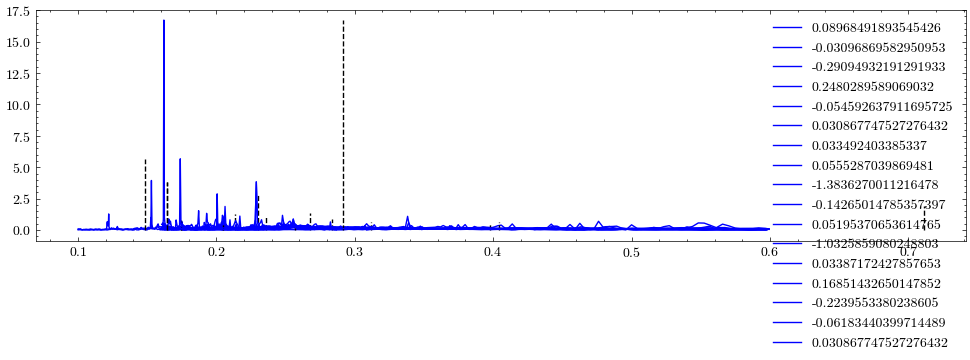

In [5]:
files = list_files(directory, pattern)
event_modes = []
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,3))
file_axes = {}
for file in files:
    print(file)
    try:
        event = quakeio.read(file, exclusions=["*filter*", "*date*"])
        print("peak acceleration (cm/s/s):", event["peak_accel"])
        inputs, dt = extract_channels(event, data_conf["inputs"], decimate=data_conf["d"])
        outpts, dt = extract_channels(event, data_conf["outputs"], decimate=data_conf["d"])
        realization = ssid.system(method="srim", inputs=inputs, outputs=outpts, **conf)
    except Exception as e:
        print(e)
        continue
    ss_modes = modal.system_modes(realization,dt,nt=inputs.shape[1])
    event_modes.append(list(ss_modes.values()))
    print_modes(ss_modes)
    periods, amplitudes = spec.fourier_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, **conf)
    ax.plot(periods, 0.1*amplitudes, label=event["peak_accel"]/980.7, color="blue")
    # periods, amplitudes = spec.response_transfer(inputs=inputs[0], outputs=outpts[0], step=dt, periods=np.linspace(*conf["period_band"],50), **conf)
    # ax.plot(periods, amplitudes, color="green")
    ax.vlines([1/value["freq"] for value in ss_modes.values()][0],0,0.1*max(amplitudes),color='k',linestyles='dashed')
ax.legend()
event_frequencies = mode_statistics(event_modes, "freq")